In [62]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
%matplotlib inline
import os
import datetime
from sklearn.linear_model import LinearRegression  
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from scipy import stats
from scipy.stats import pearsonr
import joblib
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')


In [63]:
sns.set_style("white", {'axes.grid' : False})
sns.set_palette("tab20", 16)
sns.set(font="Calibri")
sns.set_context('talk')

In [64]:
df = pd.read_csv('train_set.csv', parse_dates= ['created_at'])
df

,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5
0,2019-12-02 08:00:00+03:00,USEmbassy,74.088667,83.767111,0.000000,0.000000,0.962917,21.475000,0.299255,32.592686,1199,4374,21,14,6834,130,95.0
1,2020-03-17 02:00:00+03:00,USEmbassy,88.350233,96.003023,86.993256,107.929767,0.967667,19.233333,0.299255,32.592686,1199,4374,21,14,6834,130,139.0
2,2019-10-13 05:00:00+03:00,USEmbassy,47.540513,58.672308,48.684103,60.505128,0.999250,18.916667,0.299255,32.592686,1199,4374,21,14,6834,130,46.0
3,2020-04-04 11:00:00+03:00,USEmbassy,24.567619,27.151429,23.406667,27.316429,0.783500,25.475000,0.299255,32.592686,1199,4374,21,14,6834,130,33.0
4,2020-03-22 20:00:00+03:00,USEmbassy,46.644857,57.555143,46.195143,60.075714,0.721833,22.916667,0.299255,32.592686,1199,4374,21,14,6834,130,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10927,2020-01-22 04:00:00+03:00,USEmbassy,128.917907,134.155814,124.504884,138.842326,0.670000,20.091667,0.299255,32.592686,1199,4374,21,14,6834,130,116.0
10928,2020-01-30 20:00:00+03:00,USEmbassy,29.963721,33.015814,28.620698,33.943256,0.834167,22.450000,0.299255,32.592686,1199,4374,21,14,6834,130,38.0
10929,2020-12-17 13:00:00+03:00,Makerere,51.620000,63.634444,49.422222,61.824444,0.629333,25.108333,0.333501,32.568561,1233,6340,21,28,8518,475,38.3
10930,2020-02-05 21:00:00+03:00,USEmbassy,54.548864,65.714318,51.484773,65.361818,0.888333,20.733333,0.299255,32.592686,1199,4374,21,14,6834,130,67.0


In [65]:
df.shape

(10932, 17)

In [66]:
def get_date_features(df_tmp):
    D_COL = 'created_at'
    for attr in ['hour', 'day', 'dayofweek', 'month','week', 'year']:
        df_tmp[f'{D_COL}_{attr}'] = getattr(df_tmp[D_COL].dt, attr)
    return df_tmp

In [67]:
data = get_date_features(df)

In [68]:
data

,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,...,landform_270m,population,dist_major_road,ref_pm2_5,created_at_hour,created_at_day,created_at_dayofweek,created_at_month,created_at_week,created_at_year
0,2019-12-02 08:00:00+03:00,USEmbassy,74.088667,83.767111,0.000000,0.000000,0.962917,21.475000,0.299255,32.592686,...,14,6834,130,95.0,8,2,0,12,49,2019
1,2020-03-17 02:00:00+03:00,USEmbassy,88.350233,96.003023,86.993256,107.929767,0.967667,19.233333,0.299255,32.592686,...,14,6834,130,139.0,2,17,1,3,12,2020
2,2019-10-13 05:00:00+03:00,USEmbassy,47.540513,58.672308,48.684103,60.505128,0.999250,18.916667,0.299255,32.592686,...,14,6834,130,46.0,5,13,6,10,41,2019
3,2020-04-04 11:00:00+03:00,USEmbassy,24.567619,27.151429,23.406667,27.316429,0.783500,25.475000,0.299255,32.592686,...,14,6834,130,33.0,11,4,5,4,14,2020
4,2020-03-22 20:00:00+03:00,USEmbassy,46.644857,57.555143,46.195143,60.075714,0.721833,22.916667,0.299255,32.592686,...,14,6834,130,60.0,20,22,6,3,12,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10927,2020-01-22 04:00:00+03:00,USEmbassy,128.917907,134.155814,124.504884,138.842326,0.670000,20.091667,0.299255,32.592686,...,14,6834,130,116.0,4,22,2,1,4,2020
10928,2020-01-30 20:00:00+03:00,USEmbassy,29.963721,33.015814,28.620698,33.943256,0.834167,22.450000,0.299255,32.592686,...,14,6834,130,38.0,20,30,3,1,5,2020
10929,2020-12-17 13:00:00+03:00,Makerere,51.620000,63.634444,49.422222,61.824444,0.629333,25.108333,0.333501,32.568561,...,28,8518,475,38.3,13,17,3,12,51,2020
10930,2020-02-05 21:00:00+03:00,USEmbassy,54.548864,65.714318,51.484773,65.361818,0.888333,20.733333,0.299255,32.592686,...,14,6834,130,67.0,21,5,2,2,6,2020


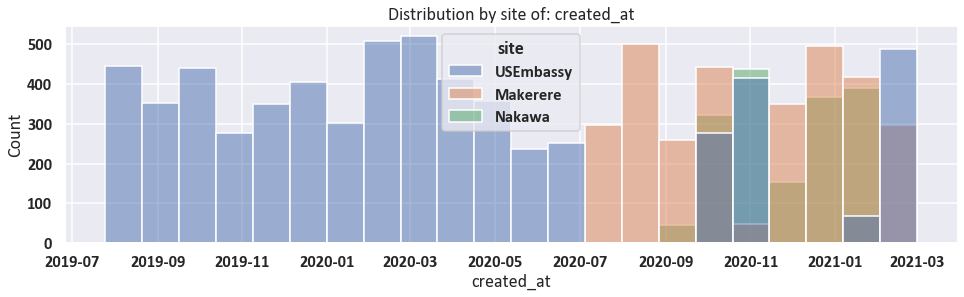

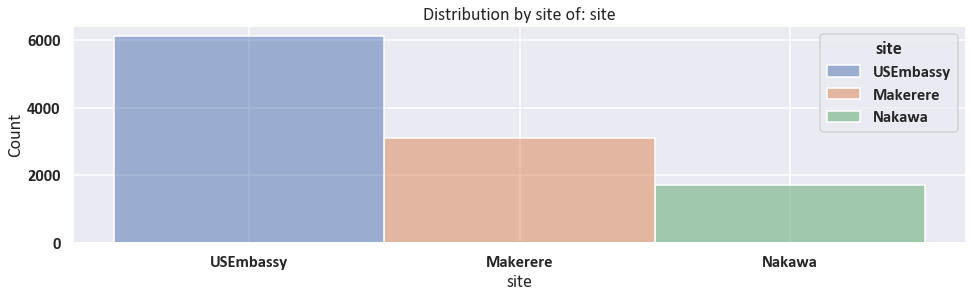

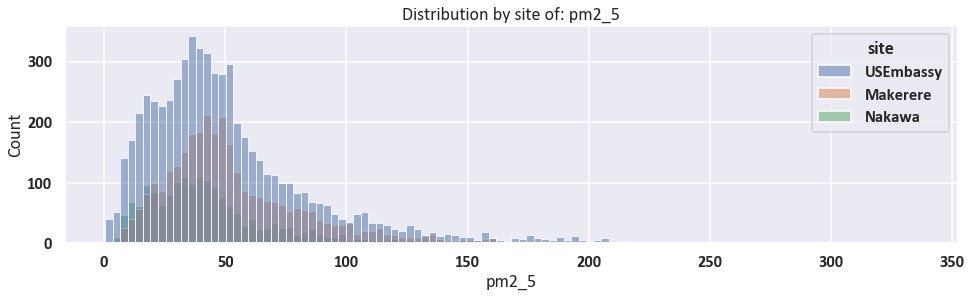

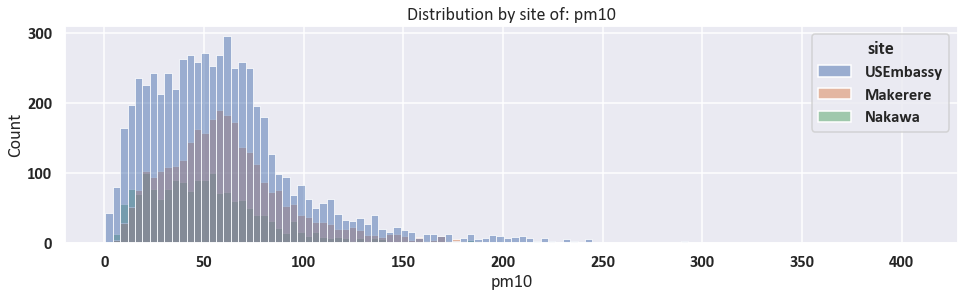

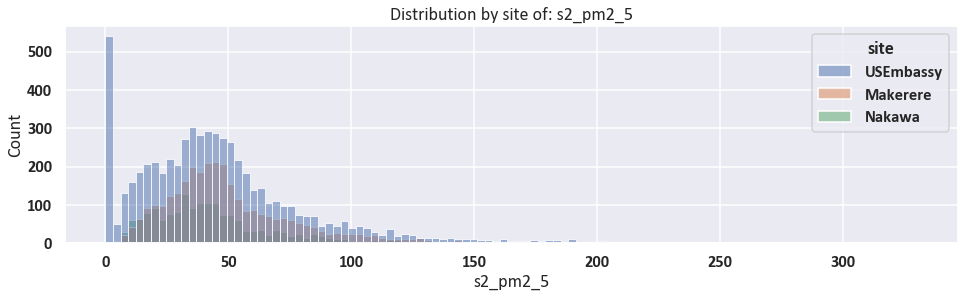

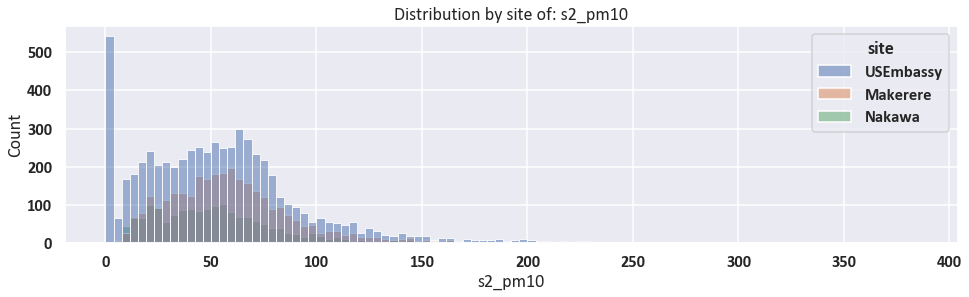

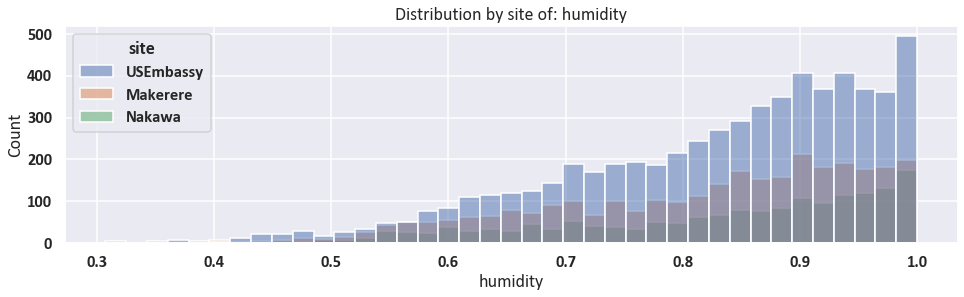

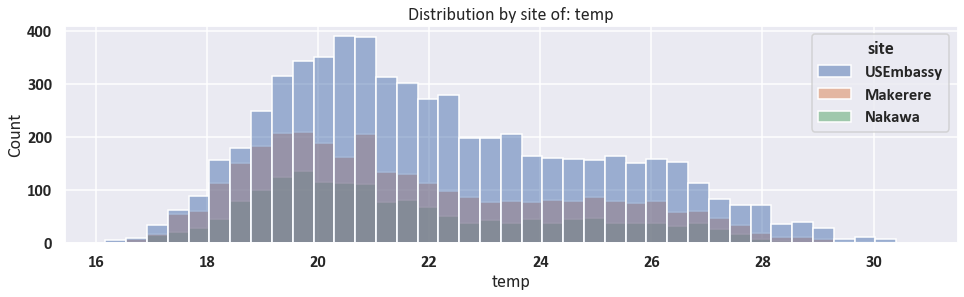

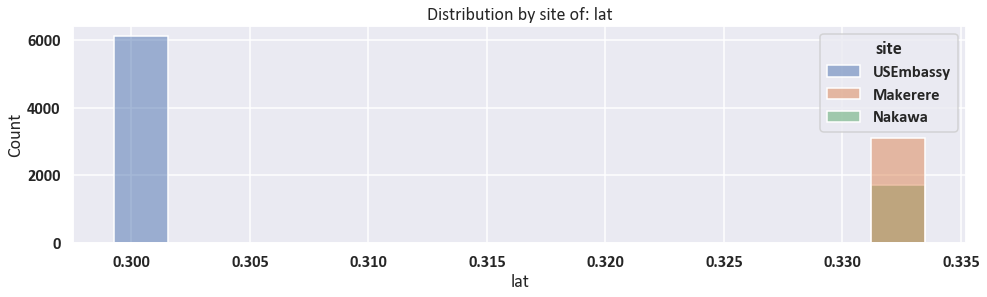

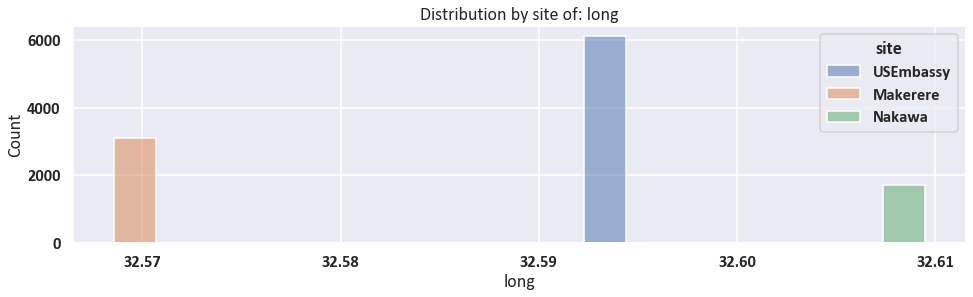

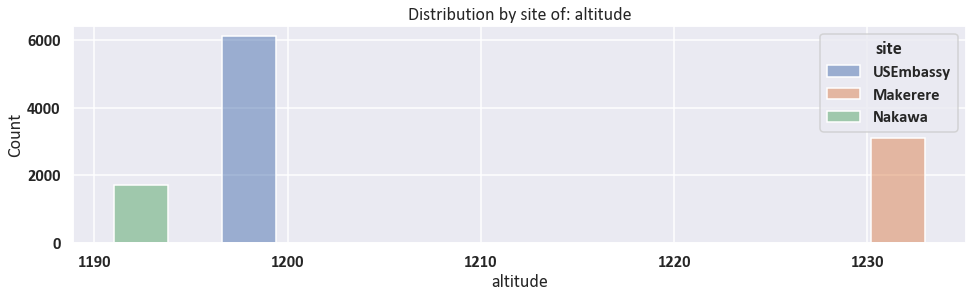

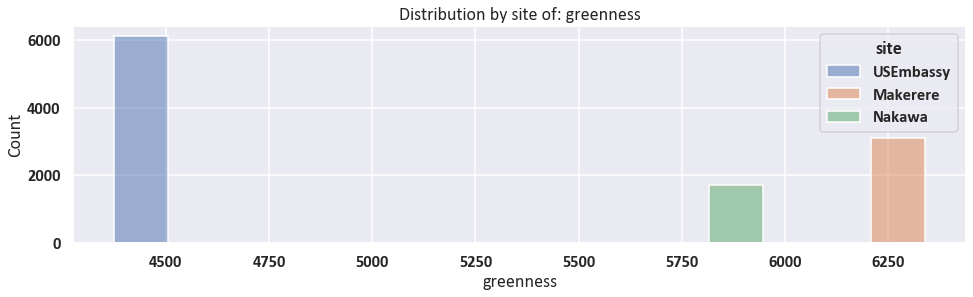

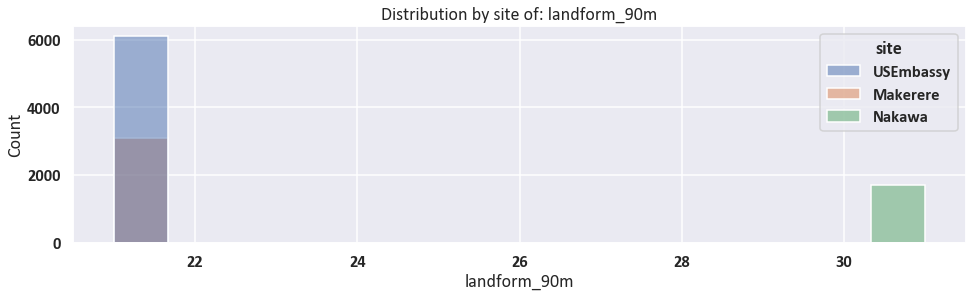

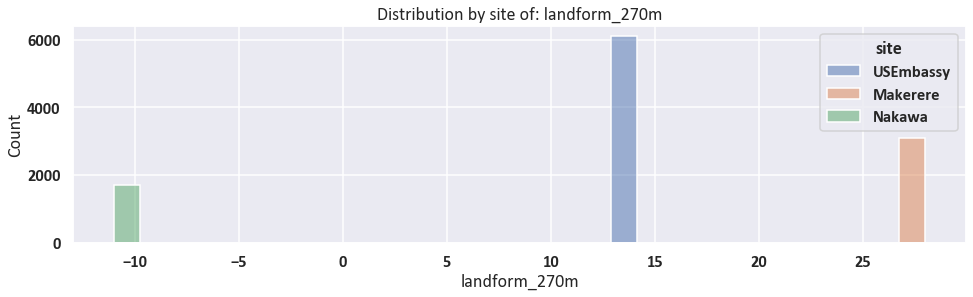

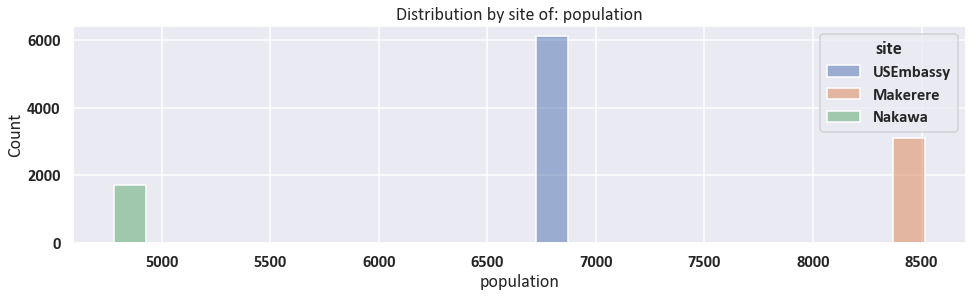

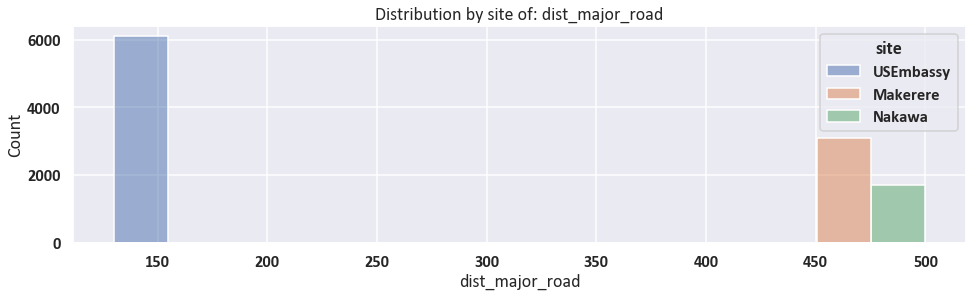

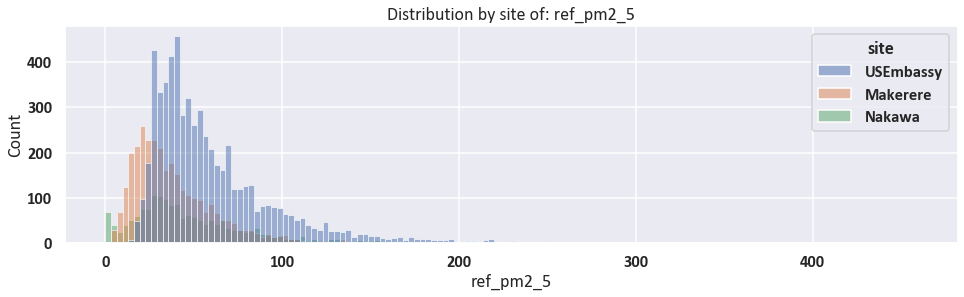

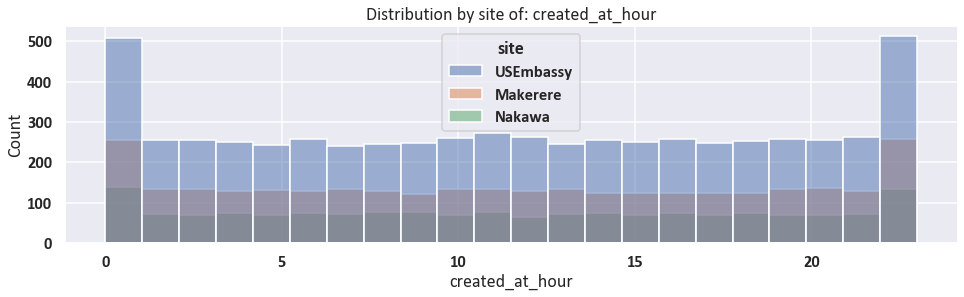

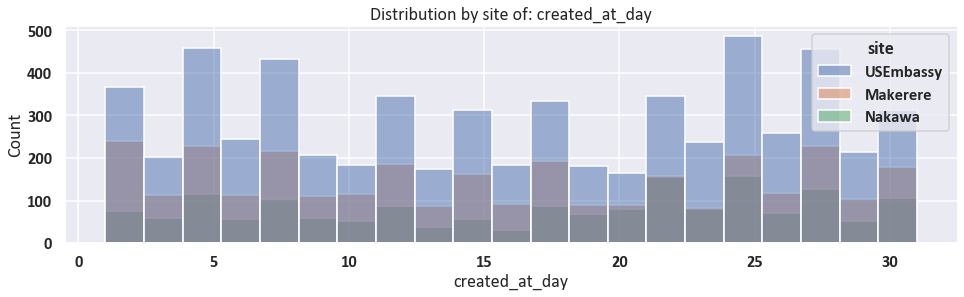

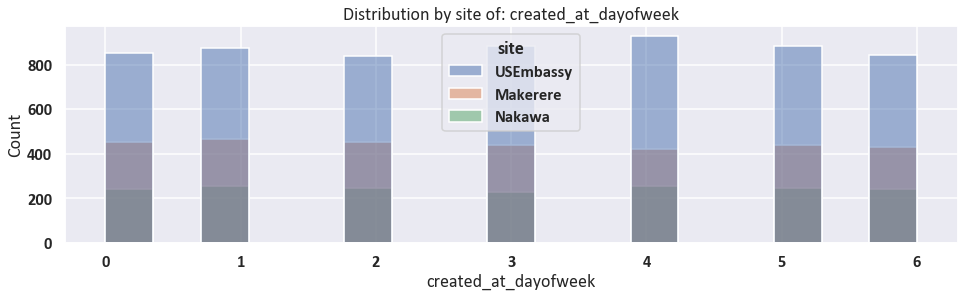

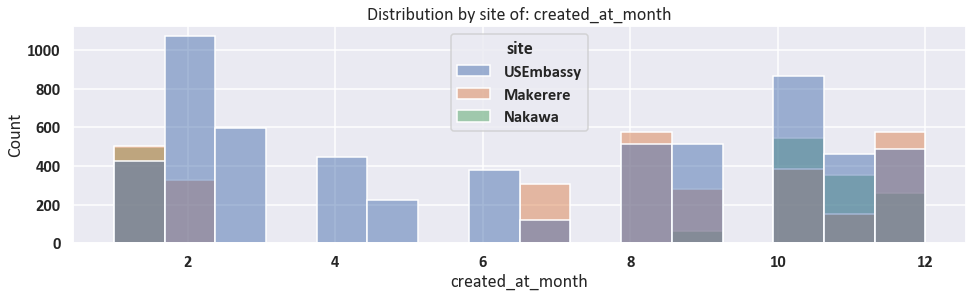

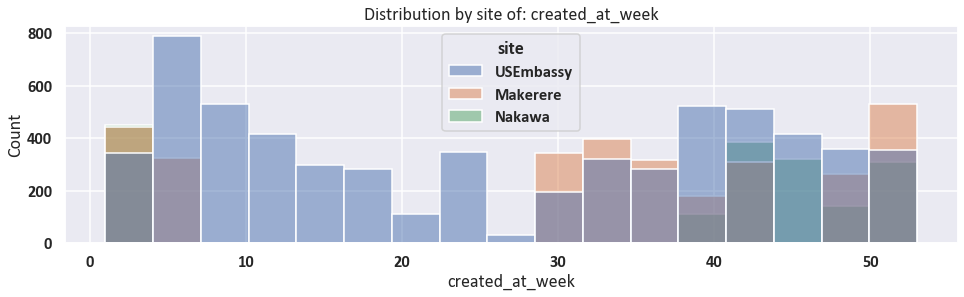

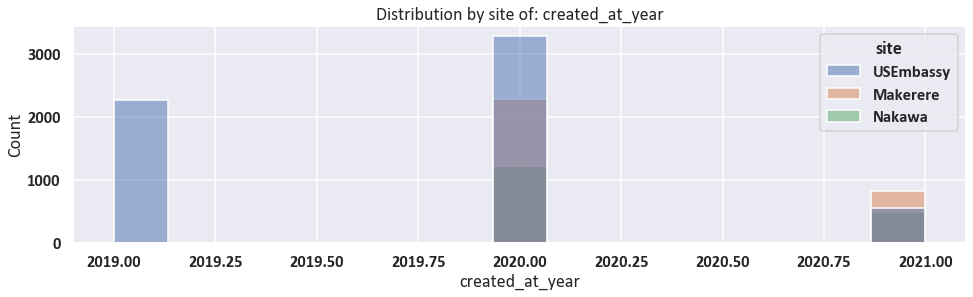

In [69]:
for col in data.columns:
    fig, ax = plt.subplots(figsize=(16,4))
    sns.histplot(data=data, x=col, hue='site')
    plt.title('Distribution by site of: ' +str(col))
    plt.show()

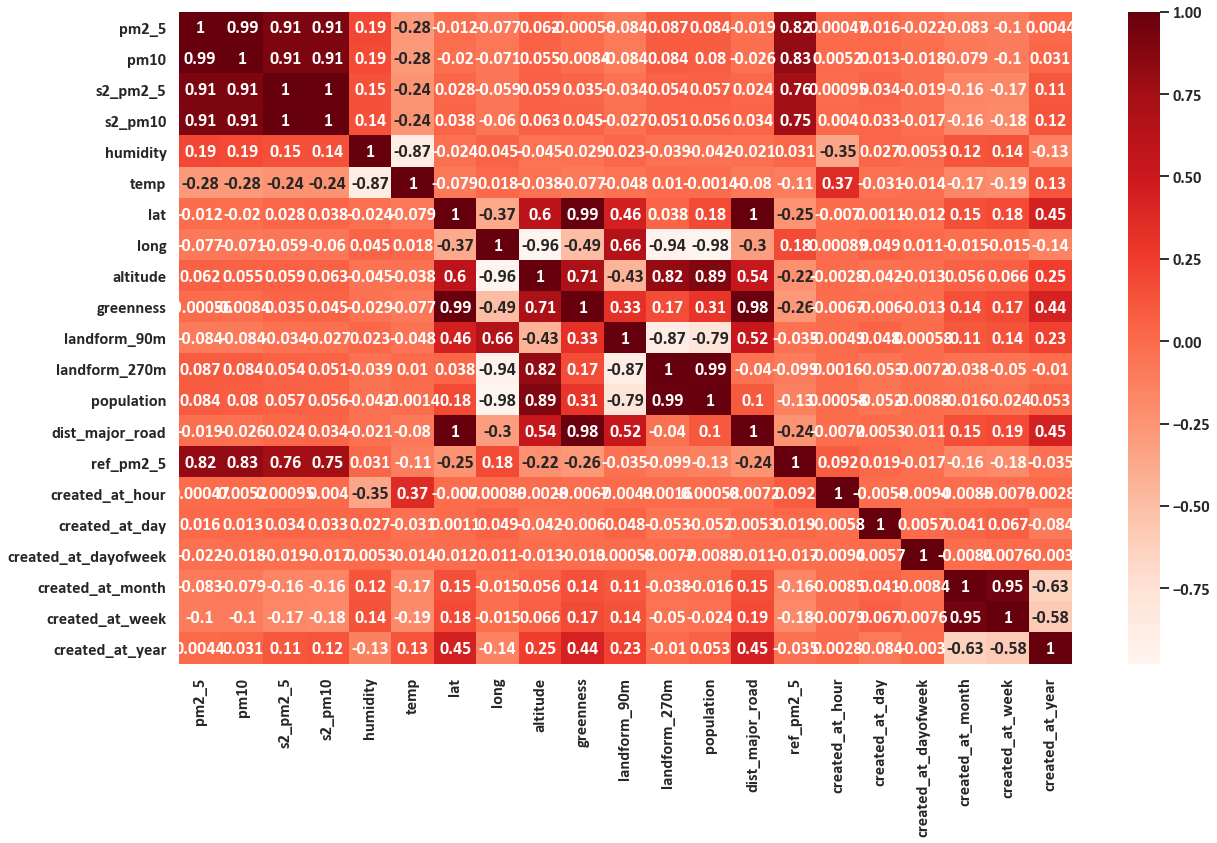

In [70]:
plt.figure(figsize=(20,12))
data_correlations =data.corr()
sns.heatmap(data_correlations, annot=True, cmap=plt.cm.Reds)

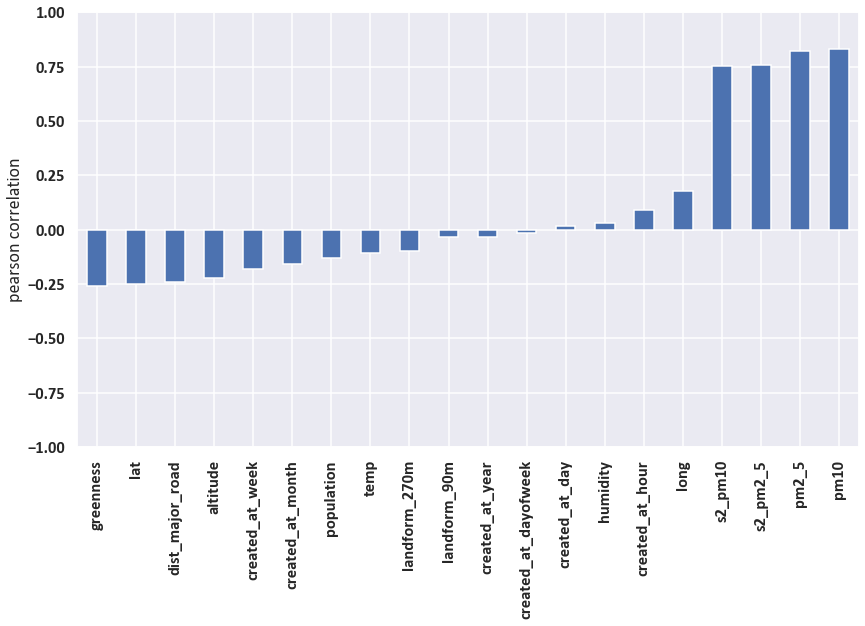

greenness              -0.260556
lat                    -0.250891
dist_major_road        -0.243103
altitude               -0.222725
created_at_week        -0.181289
created_at_month       -0.158169
population             -0.132610
temp                   -0.109582
landform_270m          -0.098641
landform_90m           -0.035147
created_at_year        -0.034572
created_at_dayofweek   -0.016898
created_at_day          0.018598
humidity                0.030603
created_at_hour         0.092069
long                    0.176348
s2_pm10                 0.752732
s2_pm2_5                0.755162
pm2_5                   0.821103
pm10                    0.829827
dtype: float64

In [71]:
y = (data['ref_pm2_5'])
fields = ['created_at', 'site', 'pm2_5', 'pm10', 's2_pm2_5', 's2_pm10',
       'humidity', 'temp', 'lat', 'long', 'altitude', 'greenness',
       'landform_90m', 'landform_270m', 'population', 'dist_major_road',
        'created_at_hour', 'created_at_day', 'created_at_dayofweek', 'created_at_month', 'created_at_week',
       'created_at_year']
correlations = data[fields].corrwith(y)
correlations.sort_values(inplace=True)


plt.figure(figsize=(14,8))
ax = correlations.plot(kind='bar')
ax.set(ylim=[-1, 1], ylabel='pearson correlation')
plt.show()

correlations

In [72]:
data.columns

Index(['created_at', 'site', 'pm2_5', 'pm10', 's2_pm2_5', 's2_pm10',
       'humidity', 'temp', 'lat', 'long', 'altitude', 'greenness',
       'landform_90m', 'landform_270m', 'population', 'dist_major_road',
       'ref_pm2_5', 'created_at_hour', 'created_at_day',
       'created_at_dayofweek', 'created_at_month', 'created_at_week',
       'created_at_year'],
      dtype='object')

In [73]:
def visualise_prediction_vs_actual(df_, method):
    fig = plt.figure(figsize=(14,6))
    plt.rcParams.update({'font.size':14, 'font.weight':'bold'})
    plt.plot(df_.index, 
             df_['Actual'], linestyle='solid', label='Actual')  
    plt.plot(df_.index, 
             df_['Predicted'], linestyle='solid', label='Predicted')

    chart_title =  'Actual Vs Predicted using '+ method
    plt.title(chart_title,fontsize=20)
    plt.ylabel('PM2.5', fontsize=20)
    plt.xlabel('index', fontsize=20)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    fig.savefig(chart_title+'.png')
    
    
def get_model_metrics(y_test, y_pred):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mse =  metrics.mean_squared_error(y_test, y_pred)
    actual = pd.Series(y_test)
    predicted = pd.Series(y_pred)
    correlation = actual.corr(predicted)
    r_squared = round((correlation*correlation),4)
    print('Mean Absolute Error: ',mae)     
    print('Root Mean Squared Error: ', rmse)
    print('Mean Squared Error: ',mse) 
    print('Correlation: ', correlation)
    print('R-Squared Value: ', r_squared)
    return mae, rmse, mse, correlation, r_squared



### LINEAR REGRESSION

10932
10932
9.477732260949793
[0.84299408]
      Actual  Predicted
0       25.0  19.675662
1       51.0  40.567354
2       22.1  25.396566
3       31.0  48.926483
4       56.7  43.885255
...      ...        ...
2182    66.0  58.857948
2183    25.0  18.549847
2184    37.0  39.691215
2185    47.0  44.250589
2186    20.8  40.881135

[2187 rows x 2 columns]
Mean Absolute Error:  13.412170283914449
Root Mean Squared Error:  21.161216811396272
Mean Squared Error:  447.7970969389202
Correlation:  0.8154916505972466
R-Squared Value:  0.665


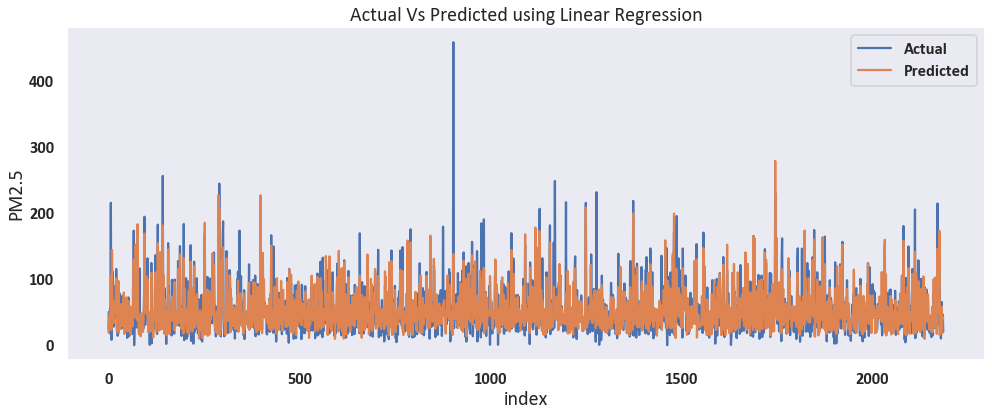

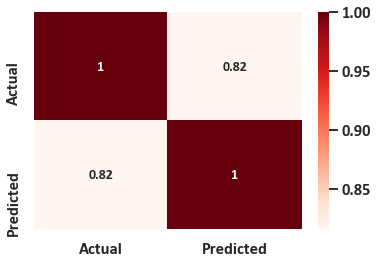

In [74]:
X_data = data['pm2_5'].values
X_data = X_data.reshape((-1, 1))
y_data = data['ref_pm2_5'].values
print(X_data.shape[0])
print(y_data.shape[0])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)
joblib.dump(regressor, 'regressor_model.pkl')
y_pred = regressor.predict(X_test)
df_ = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
print(df_)

get_model_metrics(y_test, y_pred)
visualise_prediction_vs_actual(df_, 'Linear Regression')

actual_predicted_correlations =df_.corr()
correlations = df_['Actual'].corr(df_['Predicted'])
all_features_corr_plot = sns.heatmap(actual_predicted_correlations, annot=True, cmap=plt.cm.Reds)
plt.show()



In [75]:
df_

,Actual,Predicted
0,25.0,19.675662
1,51.0,40.567354
2,22.1,25.396566
3,31.0,48.926483
4,56.7,43.885255
...,...,...
2182,66.0,58.857948
2183,25.0,18.549847
2184,37.0,39.691215
2185,47.0,44.250589


      Actual  Predicted
0       25.0  24.728238
1       51.0  38.729903
2       22.1  28.643375
3       31.0  48.330650
4       56.7  42.091945
...      ...        ...
2182    66.0  61.288469
2183    25.0  23.961639
2184    37.0  37.953014
2185    47.0  42.502339
2186    20.8  39.019238

[2187 rows x 2 columns]
Mean Absolute Error:  13.142780736761434
Root Mean Squared Error:  21.026411378480216
Mean Squared Error:  442.1099754570823
Correlation:  0.8182843843128246
R-Squared Value:  0.6696


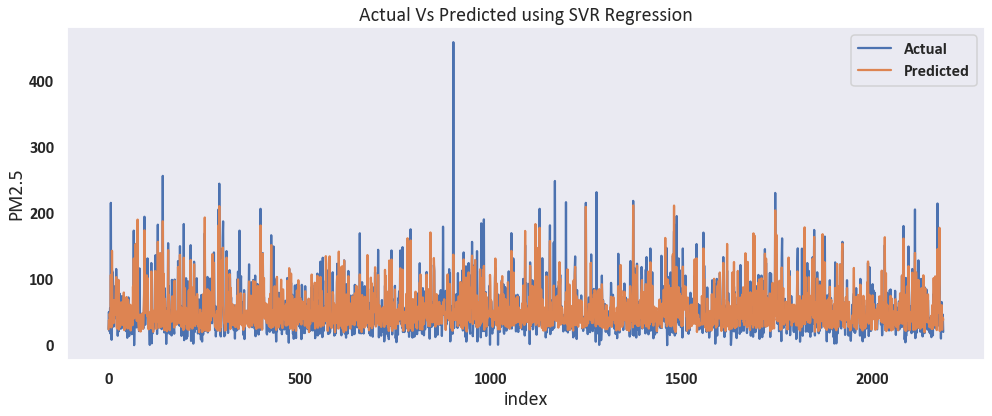

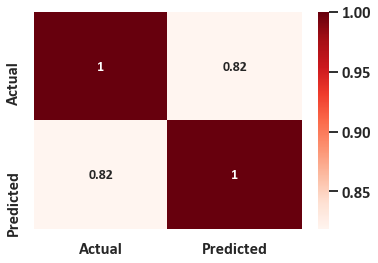

['svr_model.pkl']

In [76]:
svr = SVR(kernel='rbf', degree=3, C=100, epsilon=0.1)
# fit the model by fitting the SVM regressor to the training data
svr.fit(X_train,y_train)

svr_predictions = svr.predict(X_test)
df_ = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': svr_predictions.flatten()})
print(df_)

get_model_metrics(y_test, svr_predictions)
visualise_prediction_vs_actual(df_, 'SVR Regression')

actual_predicted_correlations =df_.corr()
correlations = df_['Actual'].corr(df_['Predicted'])
all_features_corr_plot = sns.heatmap(actual_predicted_correlations, annot=True, cmap=plt.cm.Reds)
plt.show()

joblib.dump(svr, 'svr_model.pkl')

### MULTILINEAR REGRESSION

### SVM

### RANDOM FOREST

### GRADIENT BOOSTING TREE

### NEURAL  NETWORKS

# Evaluation on Held out test set

In [77]:
df_test = pd.read_csv('test_set.csv', parse_dates= ['created_at'])
data_test = get_date_features(df_test)
df_test_solution = pd.read_csv('test_solution.csv')

In [78]:
df_test

,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,...,landform_90m,landform_270m,population,dist_major_road,created_at_hour,created_at_day,created_at_dayofweek,created_at_month,created_at_week,created_at_year
0,2020-03-20 12:00:00+03:00,USEmbassy,9.903636,10.259545,8.852727,10.097727,0.748000,26.491667,0.299255,32.592686,...,21,14,6834,130,12,20,4,3,12,2020
1,2019-10-12 06:00:00+03:00,USEmbassy,38.428333,45.940714,40.087143,48.159762,0.995000,18.225000,0.299255,32.592686,...,21,14,6834,130,6,12,5,10,41,2019
2,2019-12-13 17:00:00+03:00,USEmbassy,13.278000,14.967333,0.000000,0.000000,0.687500,24.891667,0.299255,32.592686,...,21,14,6834,130,17,13,4,12,50,2019
3,2019-11-13 09:00:00+03:00,USEmbassy,36.304000,40.366750,89.182500,93.572500,0.868417,22.616667,0.299255,32.592686,...,21,14,6834,130,9,13,2,11,46,2019
4,2019-08-07 19:00:00+03:00,USEmbassy,56.686410,67.412308,55.048974,66.089487,0.782083,23.350000,0.299255,32.592686,...,21,14,6834,130,19,7,2,8,32,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2728,2020-01-19 00:00:00+03:00,USEmbassy,75.804091,79.502045,72.147273,80.552273,0.730833,22.300000,0.299255,32.592686,...,21,14,6834,130,0,19,6,1,3,2020
2729,2020-10-25 11:00:00+03:00,Nakawa,20.805238,22.663810,22.465238,24.824048,0.640500,26.825000,0.331740,32.609510,...,31,-11,4780,500,11,25,6,10,43,2020
2730,2021-01-13 06:00:00+03:00,Makerere,76.253333,82.311667,72.468333,81.742500,0.987333,19.291667,0.333501,32.568561,...,21,28,8518,475,6,13,2,1,2,2021
2731,2019-08-13 13:00:00+03:00,USEmbassy,37.669767,44.455581,37.168837,43.949767,0.660667,25.550000,0.299255,32.592686,...,21,14,6834,130,13,13,1,8,33,2019


In [79]:
df_test_solution

,ref_pm2_5
0,30.0
1,44.0
2,27.0
3,48.0
4,57.0
...,...
2728,75.0
2729,24.2
2730,54.0
2731,42.0


In [80]:
X_data_test = data_test['pm2_5'].values
X_data_test = X_data_test.reshape((-1, 1))
y_data_test = df_test_solution['ref_pm2_5'].values

#### Linear Regression

      Actual  Predicted
0       30.0  17.826439
1       44.0  41.872590
2       27.0  20.671008
3       48.0  40.081789
4       57.0  57.264040
...      ...        ...
2728    75.0  73.380132
2729    24.2  27.016425
2730    54.0  73.758841
2731    42.0  41.233123
2732    39.4  53.924314

[2733 rows x 2 columns]
Mean Absolute Error:  12.714493793469806
Root Mean Squared Error:  18.816872004170634
Mean Squared Error:  354.0746720213405
Correlation:  0.8474893086351872
R-Squared Value:  0.7182


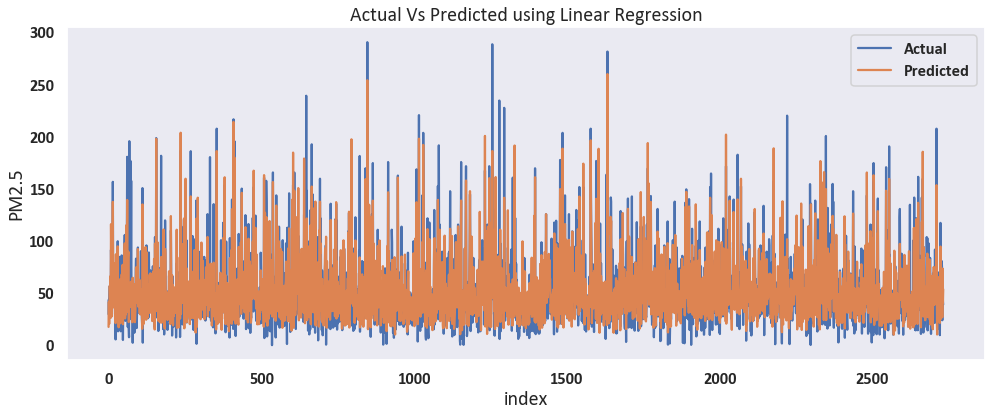

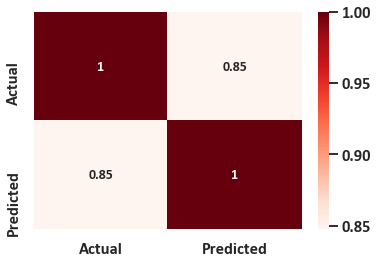

In [81]:
regressor_loaded = joblib.load('regressor_model.pkl')
y_pred_eval = regressor_loaded.predict(X_data_test)
df_ = pd.DataFrame({'Actual': y_data_test.flatten(), 'Predicted': y_pred_eval.flatten()})
print(df_)

get_model_metrics(y_data_test, y_pred_eval)
visualise_prediction_vs_actual(df_, 'Linear Regression')

actual_predicted_correlations =df_.corr()
correlations = df_['Actual'].corr(df_['Predicted'])
all_features_corr_plot = sns.heatmap(actual_predicted_correlations, annot=True, cmap=plt.cm.Reds)
plt.show()

      Actual  Predicted
0       30.0  23.484093
1       44.0  39.972714
2       27.0  25.419617
3       48.0  38.293765
4       57.0  59.404604
...      ...        ...
2728    75.0  73.911256
2729    24.2  29.672398
2730    54.0  74.222547
2731    42.0  39.350887
2732    39.4  55.109973

[2733 rows x 2 columns]
Mean Absolute Error:  12.612289658798362
Root Mean Squared Error:  18.91264805378107
Mean Squared Error:  357.6882564061888
Correlation:  0.8470048227386496
R-Squared Value:  0.7174


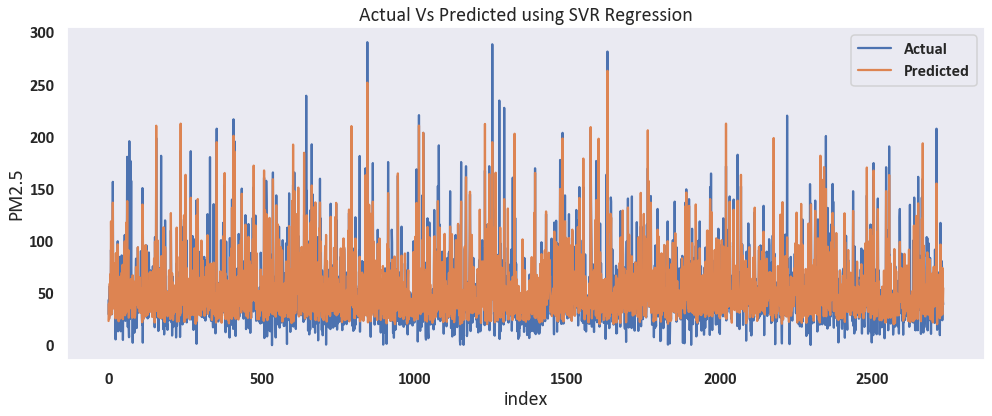

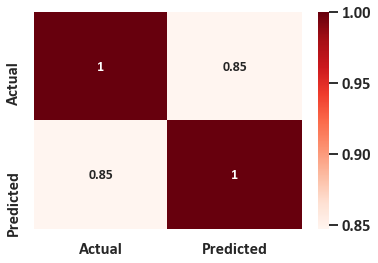

In [82]:
svr_loaded = joblib.load('svr_model.pkl')
y_pred_eval = svr_loaded.predict(X_data_test)
df_ = pd.DataFrame({'Actual': y_data_test.flatten(), 'Predicted': y_pred_eval.flatten()})
print(df_)

get_model_metrics(y_data_test, y_pred_eval)
visualise_prediction_vs_actual(df_, 'SVR Regression')

actual_predicted_correlations =df_.corr()
correlations = df_['Actual'].corr(df_['Predicted'])
all_features_corr_plot = sns.heatmap(actual_predicted_correlations, annot=True, cmap=plt.cm.Reds)
plt.show()

# MULTIPLE FEATURES 

### Feature Engineering

In [83]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
pm2_5,10932.0,51.543471,34.588032,0.567273,29.370546,43.659269,63.956750,335.433023
pm10,10932.0,59.794230,38.214016,0.595909,33.740357,54.310698,74.936473,407.713953
s2_pm2_5,10932.0,48.183486,34.259708,0.000000,26.605675,42.184865,60.999375,330.275152
s2_pm10,10932.0,56.765928,38.876526,0.000000,30.255752,52.554515,73.278125,384.627045
humidity,10926.0,0.824849,0.135233,0.307167,0.735000,0.857208,0.933729,1.000000
temp,10915.0,21.962882,2.803965,16.175000,19.775000,21.350000,24.025000,30.781818
lat,10932.0,0.314090,0.016704,0.299255,0.299255,0.299255,0.333501,0.333501
long,10932.0,32.588472,0.013861,32.568561,32.568561,32.592686,32.592686,32.609510
altitude,10932.0,1207.406696,16.369252,1191.000000,1199.000000,1199.000000,1233.000000,1233.000000
greenness,10932.0,5166.938986,904.989287,4374.000000,4374.000000,4374.000000,6340.000000,6340.000000


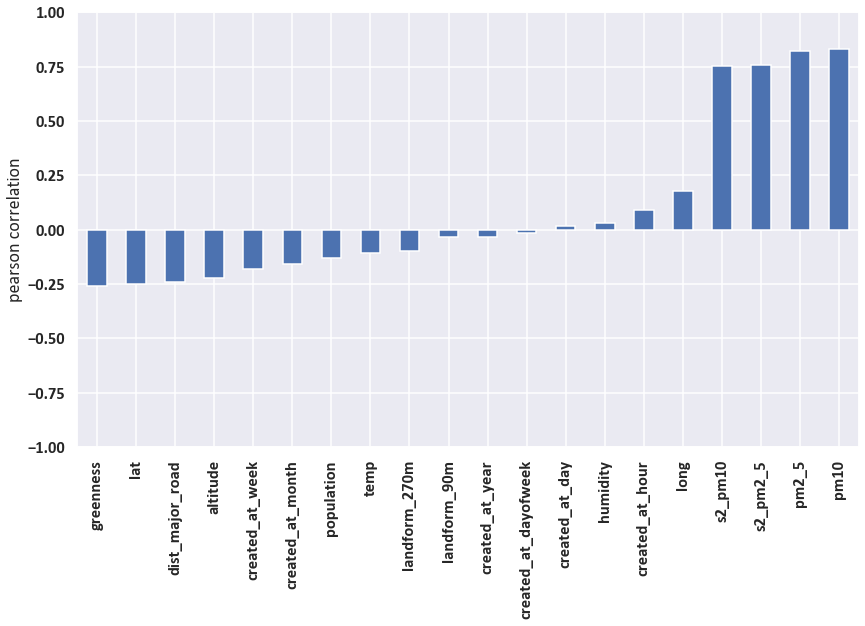

greenness              -0.260556
lat                    -0.250891
dist_major_road        -0.243103
altitude               -0.222725
created_at_week        -0.181289
created_at_month       -0.158169
population             -0.132610
temp                   -0.109582
landform_270m          -0.098641
landform_90m           -0.035147
created_at_year        -0.034572
created_at_dayofweek   -0.016898
created_at_day          0.018598
humidity                0.030603
created_at_hour         0.092069
long                    0.176348
s2_pm10                 0.752732
s2_pm2_5                0.755162
pm2_5                   0.821103
pm10                    0.829827
dtype: float64

In [84]:
y = (data['ref_pm2_5'])
#fields = list(data.columns[:-1])  # everything except "color"
fields = ['created_at', 'site', 'pm2_5', 'pm10', 's2_pm2_5', 's2_pm10',
       'humidity', 'temp', 'lat', 'long', 'altitude', 'greenness',
       'landform_90m', 'landform_270m', 'population', 'dist_major_road',
        'created_at_hour', 'created_at_day', 'created_at_dayofweek', 'created_at_month', 'created_at_week',
       'created_at_year']
correlations = data[fields].corrwith(y)
correlations.sort_values(inplace=True)


plt.figure(figsize=(14,8))
ax = correlations.plot(kind='bar')
ax.set(ylim=[-1, 1], ylabel='pearson correlation')
plt.show()

correlations

In [85]:
data.head().T

,0,1,2,3,4
created_at,2019-12-02 08:00:00+03:00,2020-03-17 02:00:00+03:00,2019-10-13 05:00:00+03:00,2020-04-04 11:00:00+03:00,2020-03-22 20:00:00+03:00
site,USEmbassy,USEmbassy,USEmbassy,USEmbassy,USEmbassy
pm2_5,74.0887,88.3502,47.5405,24.5676,46.6449
pm10,83.7671,96.003,58.6723,27.1514,57.5551
s2_pm2_5,0,86.9933,48.6841,23.4067,46.1951
s2_pm10,0,107.93,60.5051,27.3164,60.0757
humidity,0.962917,0.967667,0.99925,0.7835,0.721833
temp,21.475,19.2333,18.9167,25.475,22.9167
lat,0.299255,0.299255,0.299255,0.299255,0.299255
long,32.5927,32.5927,32.5927,32.5927,32.5927


In [86]:
ww = data[data['created_at_week']==12]
ww

,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,...,landform_270m,population,dist_major_road,ref_pm2_5,created_at_hour,created_at_day,created_at_dayofweek,created_at_month,created_at_week,created_at_year
1,2020-03-17 02:00:00+03:00,USEmbassy,88.350233,96.003023,86.993256,107.929767,0.967667,19.233333,0.299255,32.592686,...,14,6834,130,139.0,2,17,1,3,12,2020
4,2020-03-22 20:00:00+03:00,USEmbassy,46.644857,57.555143,46.195143,60.075714,0.721833,22.916667,0.299255,32.592686,...,14,6834,130,60.0,20,22,6,3,12,2020
211,2020-03-17 00:00:00+03:00,USEmbassy,96.291628,105.239070,93.501395,117.668140,0.928167,20.125000,0.299255,32.592686,...,14,6834,130,169.0,0,17,1,3,12,2020
415,2020-03-16 00:00:00+03:00,USEmbassy,92.994419,97.221163,89.195814,98.998372,0.931583,20.716667,0.299255,32.592686,...,14,6834,130,99.0,0,16,0,3,12,2020
433,2020-03-20 02:00:00+03:00,USEmbassy,12.571818,13.166364,12.116136,13.555682,0.890333,21.025000,0.299255,32.592686,...,14,6834,130,29.0,2,20,4,3,12,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10424,2020-03-20 15:00:00+03:00,USEmbassy,18.501591,19.856136,17.980682,20.633636,0.715333,27.083333,0.299255,32.592686,...,14,6834,130,33.0,15,20,4,3,12,2020
10549,2020-03-20 09:00:00+03:00,USEmbassy,17.858889,18.983778,16.711333,19.305778,0.862167,23.425000,0.299255,32.592686,...,14,6834,130,35.0,9,20,4,3,12,2020
10626,2020-03-21 13:00:00+03:00,USEmbassy,10.205333,10.554222,9.080667,10.465111,0.703250,26.733333,0.299255,32.592686,...,14,6834,130,29.0,13,21,5,3,12,2020
10713,2020-03-17 15:00:00+03:00,USEmbassy,35.440698,42.532326,35.860000,48.633023,0.841000,23.600000,0.299255,32.592686,...,14,6834,130,72.0,15,17,1,3,12,2020


In [87]:
## deal with null values
## replace values for s2 with s1
## one hot encode
## transformation on lat & long

In [88]:
data[data.isna().any(axis=1)]

,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,...,landform_270m,population,dist_major_road,ref_pm2_5,created_at_hour,created_at_day,created_at_dayofweek,created_at_month,created_at_week,created_at_year
861,2019-12-11 01:00:00+03:00,USEmbassy,31.267045,36.877500,0.000000,0.000000,0.982500,NaN,0.299255,32.592686,...,14,6834,130,36.0,1,11,2,12,50,2019
1190,2019-12-11 03:00:00+03:00,USEmbassy,35.550000,43.474634,0.000000,0.000000,0.995833,NaN,0.299255,32.592686,...,14,6834,130,46.0,3,11,2,12,50,2019
1391,2019-12-11 06:00:00+03:00,USEmbassy,19.427273,22.002045,0.000000,0.000000,1.000000,NaN,0.299255,32.592686,...,14,6834,130,30.0,6,11,2,12,50,2019
1529,2019-12-11 11:00:00+03:00,USEmbassy,29.901111,34.643556,0.000000,0.000000,0.780000,NaN,0.299255,32.592686,...,14,6834,130,41.0,11,11,2,12,50,2019
2274,2021-01-29 16:00:00+03:00,USEmbassy,28.912727,42.107727,32.221818,38.336818,NaN,23.008333,0.299255,32.592686,...,14,6834,130,40.0,16,29,4,1,4,2021
3277,2020-11-10 16:00:00+03:00,Nakawa,26.381190,30.775952,26.815238,32.159524,NaN,22.566667,0.331740,32.609510,...,-11,4780,500,0.8,16,10,1,11,46,2020
3335,2019-12-11 07:00:00+03:00,USEmbassy,32.801136,39.884091,0.000000,0.000000,1.000000,NaN,0.299255,32.592686,...,14,6834,130,46.0,7,11,2,12,50,2019
4273,2019-12-11 00:00:00+03:00,USEmbassy,43.462955,55.111818,0.000000,0.000000,0.969167,NaN,0.299255,32.592686,...,14,6834,130,49.0,0,11,2,12,50,2019
4361,2020-02-25 14:00:00+03:00,USEmbassy,44.975946,52.540541,43.596486,53.765946,NaN,21.566667,0.299255,32.592686,...,14,6834,130,50.0,14,25,1,2,9,2020
5315,2019-12-20 13:00:00+03:00,USEmbassy,22.913462,23.791923,21.974231,24.215769,NaN,NaN,0.299255,32.592686,...,14,6834,130,38.0,13,20,4,12,51,2019


In [89]:
data.fillna(data.mean(), inplace=True)
#data_final = data.dropna()
data.describe()

,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,...,landform_270m,population,dist_major_road,ref_pm2_5,created_at_hour,created_at_day,created_at_dayofweek,created_at_month,created_at_week,created_at_year
count,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,...,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000
mean,51.543471,59.794230,48.183486,56.765928,0.824849,21.962882,0.314090,32.588472,1207.406696,5166.938986,...,14.052415,6990.007135,286.165843,53.018432,11.498719,16.033937,2.992682,6.865532,28.893158,2019.964874
std,34.588032,38.214016,34.259708,38.876526,0.135196,2.801783,0.016704,0.013861,16.369252,904.989287,...,12.404855,1201.835036,175.912188,35.570551,6.918048,9.107709,1.993389,3.948233,17.346758,0.615307
min,0.567273,0.595909,0.000000,0.000000,0.307167,16.175000,0.299255,32.568561,1191.000000,4374.000000,...,-11.000000,4780.000000,130.000000,0.100000,0.000000,1.000000,0.000000,1.000000,1.000000,2019.000000
25%,29.370546,33.740357,26.605675,30.255752,0.735062,19.775000,0.299255,32.568561,1199.000000,4374.000000,...,14.000000,6834.000000,130.000000,30.000000,6.000000,8.000000,1.000000,2.000000,9.000000,2020.000000
50%,43.659269,54.310698,42.184865,52.554515,0.857083,21.358333,0.299255,32.592686,1199.000000,4374.000000,...,14.000000,6834.000000,130.000000,43.900000,11.000000,16.000000,3.000000,8.000000,34.000000,2020.000000
75%,63.956750,74.936473,60.999375,73.278125,0.933667,24.016667,0.333501,32.592686,1233.000000,6340.000000,...,28.000000,8518.000000,475.000000,66.000000,18.000000,24.000000,5.000000,10.000000,43.000000,2020.000000
max,335.433023,407.713953,330.275152,384.627045,1.000000,30.781818,0.333501,32.609510,1233.000000,6340.000000,...,28.000000,8518.000000,500.000000,459.000000,23.000000,31.000000,6.000000,12.000000,53.000000,2021.000000


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10932 entries, 0 to 10931
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype                                
---  ------                --------------  -----                                
 0   created_at            10932 non-null  datetime64[ns, pytz.FixedOffset(180)]
 1   site                  10932 non-null  object                               
 2   pm2_5                 10932 non-null  float64                              
 3   pm10                  10932 non-null  float64                              
 4   s2_pm2_5              10932 non-null  float64                              
 5   s2_pm10               10932 non-null  float64                              
 6   humidity              10932 non-null  float64                              
 7   temp                  10932 non-null  float64                              
 8   lat                   10932 non-null  float64                              


In [91]:
##categorical features : 

numerical_fields = ['pm2_5', 'pm10', 's2_pm2_5', 's2_pm10','humidity', 'temp', 'lat', 'long', 'altitude', 'greenness','landform_90m', 'landform_270m', 'population', 'dist_major_road']
categorical_fields= ['site']
categorical_date_fields = ['created_at_hour', 'created_at_day', 'created_at_dayofweek', 'created_at_month', 'created_at_week','created_at_year']
fields_to_use = ['pm2_5', 'pm10', 's2_pm2_5', 's2_pm10','humidity', 'temp', 'lat', 'long', 'altitude', 
                 'greenness','landform_90m', 'landform_270m', 'population', 'dist_major_road', 
                 'created_at_hour', 'created_at_day', 'created_at_dayofweek', 'created_at_month', 
                 'created_at_week','created_at_year']
data_final = data.dropna()
data_mf_ = data_final[numerical_fields] #to use when going to scale
#data_mf_ = data_final[fields_to_use]
#data_mf_ = pd.get_dummies(data_mf_, columns=['created_at_hour','created_at_day', 'created_at_dayofweek', 'created_at_month', 'created_at_week','created_at_year'], prefix = ['created_at_hour','created_at_day', 'created_at_dayofweek', 'created_at_month', 'created_at_week','created_at_year'])


In [92]:
data_cdf = data_final[categorical_date_fields]

data_values_onehot = pd.get_dummies(data_cdf, columns=['created_at_hour','created_at_day', 'created_at_dayofweek', 'created_at_month', 'created_at_week','created_at_year'], prefix = ['created_at_hour','created_at_day', 'created_at_dayofweek', 'created_at_month', 'created_at_week','created_at_year'])

data_values_onehot.head()


,created_at_hour_0,created_at_hour_1,created_at_hour_2,created_at_hour_3,created_at_hour_4,created_at_hour_5,created_at_hour_6,created_at_hour_7,created_at_hour_8,created_at_hour_9,...,created_at_week_47,created_at_week_48,created_at_week_49,created_at_week_50,created_at_week_51,created_at_week_52,created_at_week_53,created_at_year_2019,created_at_year_2020,created_at_year_2021
0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [93]:
data_values_onehot.head().T


,0,1,2,3,4
created_at_hour_0,0,0,0,0,0
created_at_hour_1,0,0,0,0,0
created_at_hour_2,0,1,0,0,0
created_at_hour_3,0,0,0,0,0
created_at_hour_4,0,0,0,0,0
...,...,...,...,...,...
created_at_week_52,0,0,0,0,0
created_at_week_53,0,0,0,0,0
created_at_year_2019,1,0,1,0,0
created_at_year_2020,0,1,0,1,1


In [94]:
data_mf_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10932 entries, 0 to 10931
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pm2_5            10932 non-null  float64
 1   pm10             10932 non-null  float64
 2   s2_pm2_5         10932 non-null  float64
 3   s2_pm10          10932 non-null  float64
 4   humidity         10932 non-null  float64
 5   temp             10932 non-null  float64
 6   lat              10932 non-null  float64
 7   long             10932 non-null  float64
 8   altitude         10932 non-null  int64  
 9   greenness        10932 non-null  int64  
 10  landform_90m     10932 non-null  int64  
 11  landform_270m    10932 non-null  int64  
 12  population       10932 non-null  int64  
 13  dist_major_road  10932 non-null  int64  
dtypes: float64(8), int64(6)
memory usage: 1.3 MB


In [95]:
data_mf = data_mf_.dropna()
data_mf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10932 entries, 0 to 10931
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pm2_5            10932 non-null  float64
 1   pm10             10932 non-null  float64
 2   s2_pm2_5         10932 non-null  float64
 3   s2_pm10          10932 non-null  float64
 4   humidity         10932 non-null  float64
 5   temp             10932 non-null  float64
 6   lat              10932 non-null  float64
 7   long             10932 non-null  float64
 8   altitude         10932 non-null  int64  
 9   greenness        10932 non-null  int64  
 10  landform_90m     10932 non-null  int64  
 11  landform_270m    10932 non-null  int64  
 12  population       10932 non-null  int64  
 13  dist_major_road  10932 non-null  int64  
dtypes: float64(8), int64(6)
memory usage: 1.3 MB


In [96]:
scaler = MinMaxScaler()
test_scaler = MinMaxScaler()

print(data_mf.shape)
X_data_mf = data_mf.values
print(X_data_mf.shape)
y_data_mf = data_final['ref_pm2_5'].values

X_train_mf, X_test_mf, y_train_mf, y_test_mf = train_test_split(X_data_mf, y_data_mf, test_size=0.2, random_state=0)

## need to enable them when using scaling ##
scaled_training_features_original = scaler.fit_transform(X_train_mf)
scaled_testing_features_original = test_scaler.fit_transform(X_test_mf)



(10932, 14)
(10932, 14)


      Actual  Predicted
0       25.0  33.982830
1       51.0  53.197865
2       22.1  33.829426
3       31.0  35.098251
4       56.7  51.569759
...      ...        ...
2182    66.0  81.083199
2183    25.0  21.204746
2184    37.0  47.660385
2185    47.0  55.207455
2186    20.8  36.047256

[2187 rows x 2 columns]
Mean Absolute Error:  12.428968241359744
Root Mean Squared Error:  19.24732681277256
Mean Squared Error:  370.45958943767346
Correlation:  0.8839650365637615
R-Squared Value:  0.7814


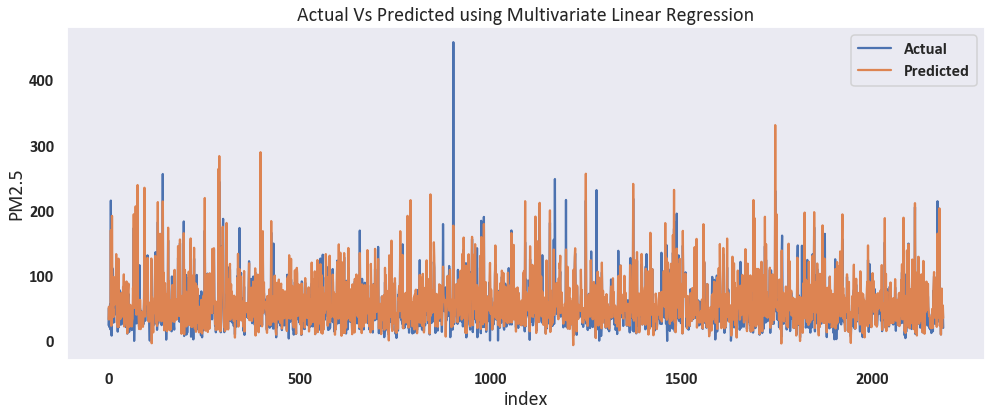

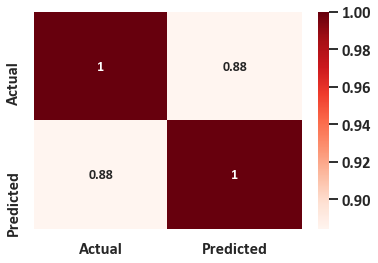

In [97]:
regressor_MLR = LinearRegression()  
#regressor_MLR.fit(X_train_mf, y_train_mf)
regressor_MLR.fit(scaled_training_features_original, y_train_mf)
joblib.dump(regressor_MLR, 'mlr_regressor_model_scaled.pkl')
#y_pred_mf = regressor_MLR.predict(X_test_mf)
y_pred_mf = regressor_MLR.predict(scaled_testing_features_original)
df_ = pd.DataFrame({'Actual': y_test_mf.flatten(), 'Predicted': y_pred_mf.flatten()})
print(df_)

get_model_metrics(y_test_mf,y_pred_mf)
visualise_prediction_vs_actual(df_, 'Multivariate Linear Regression')

actual_predicted_correlations =df_.corr()
correlations = df_['Actual'].corr(df_['Predicted'])
all_features_corr_plot = sns.heatmap(actual_predicted_correlations, annot=True, cmap=plt.cm.Reds)
plt.show()

#intercept_df = pd.DataFrame(regressor_MLR.intercept_, X_train_mf.columns, columns=['Intercept'])  
#intercept_df

In [98]:
X_data_mf

array([[  74.08866667,   83.76711111,    0.        , ...,   14.        ,
        6834.        ,  130.        ],
       [  88.35023256,   96.00302326,   86.99325581, ...,   14.        ,
        6834.        ,  130.        ],
       [  47.54051282,   58.67230769,   48.68410256, ...,   14.        ,
        6834.        ,  130.        ],
       ...,
       [  51.62      ,   63.63444444,   49.42222222, ...,   28.        ,
        8518.        ,  475.        ],
       [  54.54886364,   65.71431818,   51.48477273, ...,   14.        ,
        6834.        ,  130.        ],
       [  17.79181818,   20.17863636,    0.        , ...,   14.        ,
        6834.        ,  130.        ]])

      Actual  Predicted
0       25.0  27.318489
1       51.0  50.127073
2       22.1  28.626049
3       31.0  30.114150
4       56.7  48.872472
...      ...        ...
2182    66.0  71.509316
2183    25.0  23.197324
2184    37.0  44.298547
2185    47.0  54.604130
2186    20.8  27.385229

[2187 rows x 2 columns]
Mean Absolute Error:  8.646814451408533
Root Mean Squared Error:  16.733963229033947
Mean Squared Error:  280.0255253506602
Correlation:  0.8922131399471254
R-Squared Value:  0.796


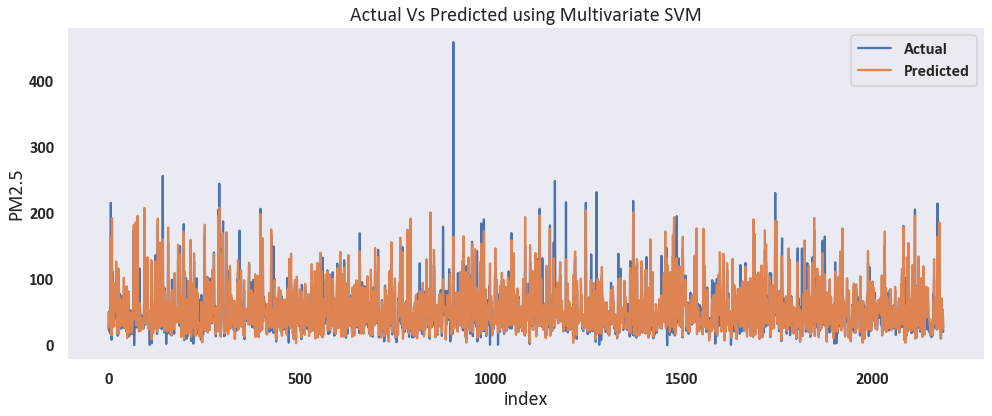

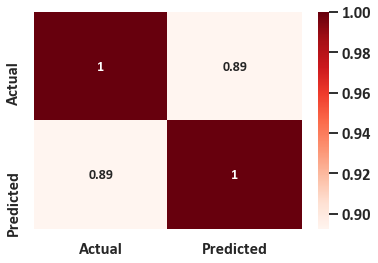

In [99]:
svr_mlr = SVR(kernel='rbf', degree=3, C=100, epsilon=0.1)
#svr_mlr.fit(X_train_mf, y_train_mf)
svr_mlr.fit(scaled_training_features_original, y_train_mf)
joblib.dump(svr_mlr, 'mlr_svr_model.pkl')
#y_pred_mf = regressor_MLR.predict(X_test_mf)
y_pred_mf = svr_mlr.predict(scaled_testing_features_original)
df_ = pd.DataFrame({'Actual': y_test_mf.flatten(), 'Predicted': y_pred_mf.flatten()})
print(df_)

get_model_metrics(y_test_mf,y_pred_mf)
visualise_prediction_vs_actual(df_, 'Multivariate SVM')

actual_predicted_correlations =df_.corr()
correlations = df_['Actual'].corr(df_['Predicted'])
all_features_corr_plot = sns.heatmap(actual_predicted_correlations, annot=True, cmap=plt.cm.Reds)
plt.show()

## random forest

      Actual  Predicted
0       25.0     26.830
1       51.0     43.460
2       22.1     25.266
3       31.0     28.242
4       56.7     41.236
...      ...        ...
2182    66.0     68.964
2183    25.0     27.240
2184    37.0     40.320
2185    47.0     46.450
2186    20.8     26.788

[2187 rows x 2 columns]
Mean Absolute Error:  7.77841426611797
Root Mean Squared Error:  15.475594077784434
Mean Squared Error:  239.49401206035662
Correlation:  0.9061387714676039
R-Squared Value:  0.8211


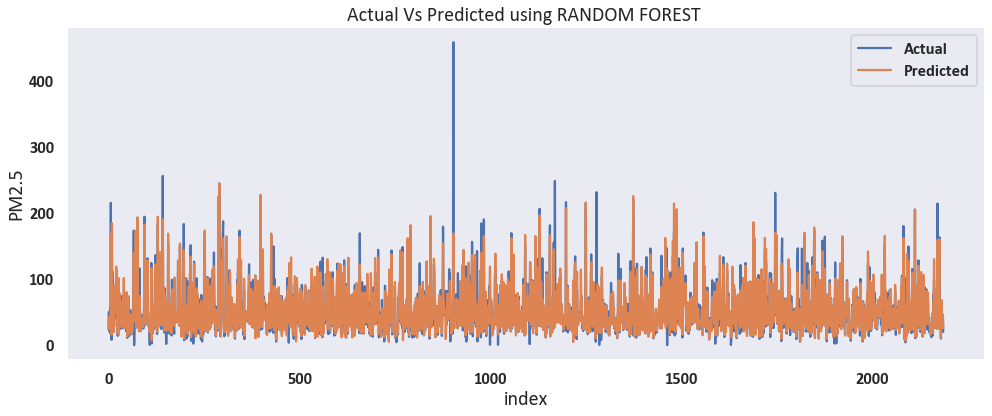

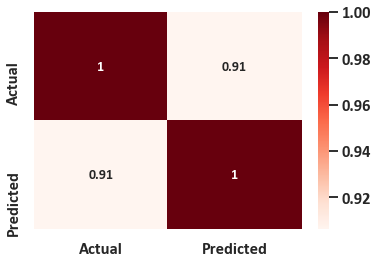

In [100]:
rfr = RandomForestRegressor(n_estimators = 50, random_state = 42) # 50 trees
rfr.fit(X_train_mf, y_train_mf) 
joblib.dump(rfr, 'randomforest_mf_model.pkl')
y_pred_mf = rfr.predict(X_test_mf)

df_ = pd.DataFrame({'Actual': y_test_mf.flatten(), 'Predicted': y_pred_mf.flatten()})
print(df_)


get_model_metrics(y_test_mf,y_pred_mf)
visualise_prediction_vs_actual(df_, 'RANDOM FOREST ')

actual_predicted_correlations =df_.corr()
correlations = df_['Actual'].corr(df_['Predicted'])
all_features_corr_plot = sns.heatmap(actual_predicted_correlations, annot=True, cmap=plt.cm.Reds)
plt.show()

In [101]:
importances = rfr.feature_importances_
indices = np.argsort(importances)[::-1] 
for f in range(X_train_mf.shape[1]): 
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])) 
    
# Get numerical feature importances
importances = list(rfr.feature_importances_)   
feature_list = list(data_mf.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('{:20} Importance: {}'.format(*pair)) for pair in feature_importances]

1. feature 1 (0.722775)
2. feature 0 (0.045322)
3. feature 4 (0.043276)
4. feature 3 (0.042232)
5. feature 5 (0.032342)
6. feature 2 (0.027475)
7. feature 7 (0.027078)
8. feature 6 (0.013425)
9. feature 11 (0.013103)
10. feature 9 (0.010710)
11. feature 12 (0.010021)
12. feature 8 (0.008960)
13. feature 13 (0.002020)
14. feature 10 (0.001260)
pm10                 Importance: 0.72277
pm2_5                Importance: 0.04532
humidity             Importance: 0.04328
s2_pm10              Importance: 0.04223
temp                 Importance: 0.03234
s2_pm2_5             Importance: 0.02748
long                 Importance: 0.02708
lat                  Importance: 0.01342
landform_270m        Importance: 0.0131
greenness            Importance: 0.01071
population           Importance: 0.01002
altitude             Importance: 0.00896
dist_major_road      Importance: 0.00202
landform_90m         Importance: 0.00126


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [102]:
feature_importancesx =  pd.DataFrame(feature_importances, columns=["feature","importance"])
feature_importancesx

,feature,importance
0,pm10,0.72277
1,pm2_5,0.04532
2,humidity,0.04328
3,s2_pm10,0.04223
4,temp,0.03234
5,s2_pm2_5,0.02748
6,long,0.02708
7,lat,0.01342
8,landform_270m,0.01310
9,greenness,0.01071


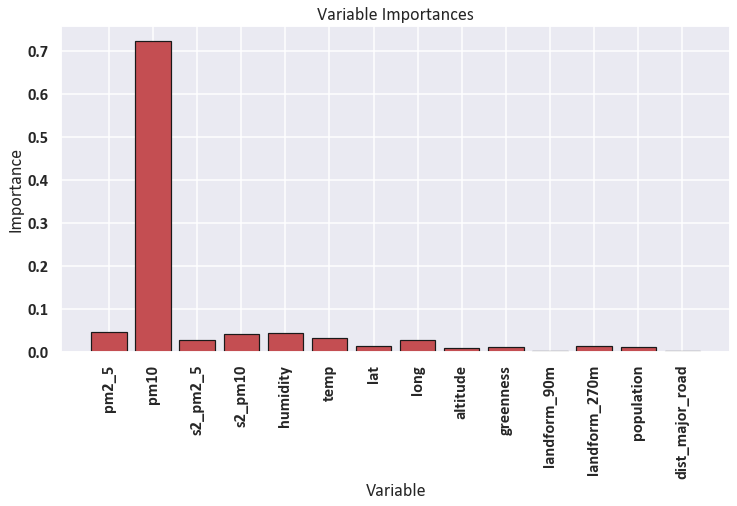

In [103]:
#feature_importancesx.plot(kind='bar',figsize=(12,6))
plt.figure(figsize=(12,6))
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

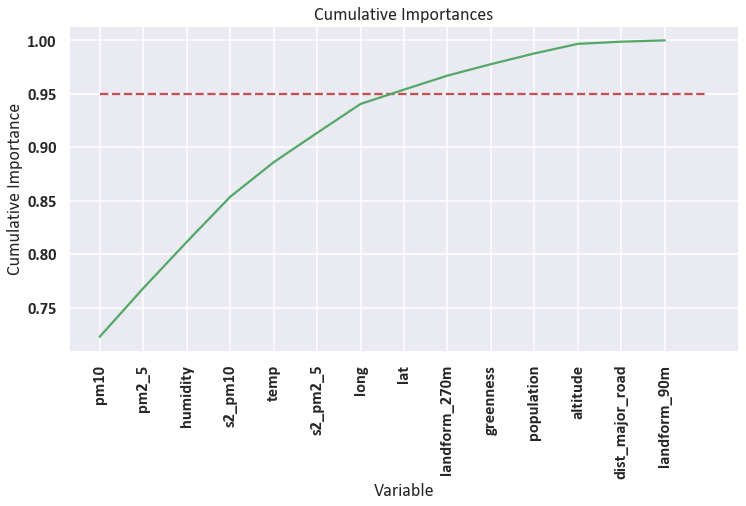

In [104]:
plt.figure(figsize=(12,6))
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [105]:
feature_importances

[('pm10', 0.72277),
 ('pm2_5', 0.04532),
 ('humidity', 0.04328),
 ('s2_pm10', 0.04223),
 ('temp', 0.03234),
 ('s2_pm2_5', 0.02748),
 ('long', 0.02708),
 ('lat', 0.01342),
 ('landform_270m', 0.0131),
 ('greenness', 0.01071),
 ('population', 0.01002),
 ('altitude', 0.00896),
 ('dist_major_road', 0.00202),
 ('landform_90m', 0.00126)]

In [106]:
# Find number of features for cumulative importance of 95%
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:24]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]


Number of features for 95% importance: 8


In [107]:
important_feature_names

['pm10',
 'pm2_5',
 'humidity',
 's2_pm10',
 'temp',
 's2_pm2_5',
 'long',
 'lat',
 'landform_270m',
 'greenness',
 'population',
 'altitude',
 'dist_major_road',
 'landform_90m']

In [108]:
# Create training and testing sets with only the important features
important_train_features = X_train_mf[:, important_indices]
important_test_features = X_test_mf[:, important_indices]
# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)



Important train features shape: (8745, 14)
Important test features shape: (2187, 14)


      Actual  Predicted
0       25.0     27.010
1       51.0     42.330
2       22.1     24.602
3       31.0     28.372
4       56.7     42.972
...      ...        ...
2182    66.0     68.970
2183    25.0     27.450
2184    37.0     40.260
2185    47.0     48.380
2186    20.8     27.379

[2187 rows x 2 columns]
Mean Absolute Error:  7.651302240512117
Root Mean Squared Error:  15.292131899629473
Mean Squared Error:  233.8492980356653
Correlation:  0.9082916974547949
R-Squared Value:  0.825


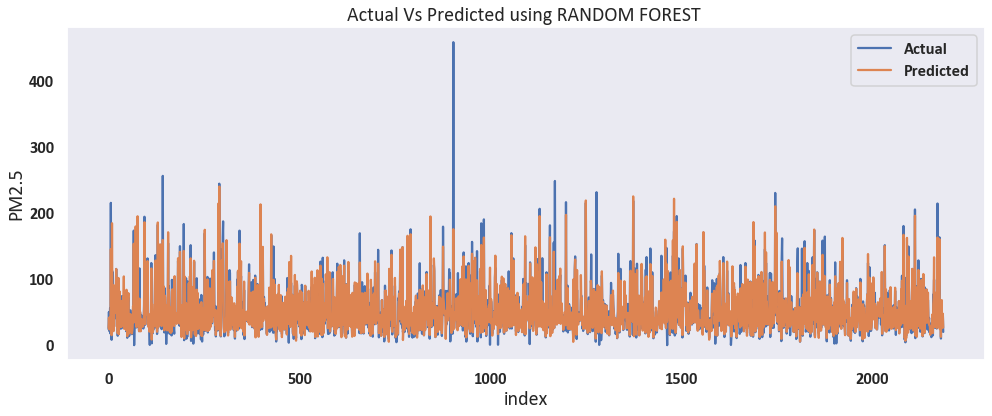

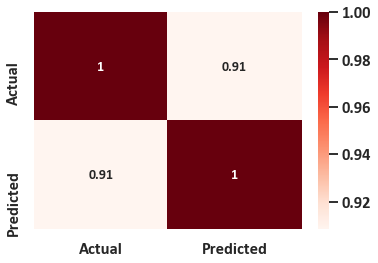

In [109]:
rfr = RandomForestRegressor(n_estimators = 100 , max_features = 'sqrt', max_depth =50, bootstrap = True, random_state = 42)
rfr.fit(important_train_features, y_train_mf) 
joblib.dump(rfr, 'selected_features_randomforest_mf_model.pkl')
y_pred_mf = rfr.predict(important_test_features)

df_ = pd.DataFrame({'Actual': y_test_mf.flatten(), 'Predicted': y_pred_mf.flatten()})
print(df_)


get_model_metrics(y_test_mf,y_pred_mf)
visualise_prediction_vs_actual(df_, 'RANDOM FOREST ')

actual_predicted_correlations =df_.corr()
correlations = df_['Actual'].corr(df_['Predicted'])
all_features_corr_plot = sns.heatmap(actual_predicted_correlations, annot=True, cmap=plt.cm.Reds)
plt.show()

In [110]:
clf = LGBMRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.4, reg_alpha=0, reg_lambda=1, max_depth=-1, random_state=42)
clf.fit(important_train_features, y_train_mf, eval_set = [(important_test_features, y_test_mf)], verbose=50, early_stopping_rounds=100, eval_metric='rmse')


Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 16.1846	valid_0's l2: 261.942
[100]	valid_0's rmse: 15.4743	valid_0's l2: 239.454
[150]	valid_0's rmse: 15.2864	valid_0's l2: 233.675
[200]	valid_0's rmse: 15.2071	valid_0's l2: 231.256
[250]	valid_0's rmse: 15.1955	valid_0's l2: 230.902
[300]	valid_0's rmse: 15.1722	valid_0's l2: 230.196
[350]	valid_0's rmse: 15.1788	valid_0's l2: 230.397
[400]	valid_0's rmse: 15.1699	valid_0's l2: 230.126
[450]	valid_0's rmse: 15.1908	valid_0's l2: 230.76
[500]	valid_0's rmse: 15.1893	valid_0's l2: 230.714
Early stopping, best iteration is:
[402]	valid_0's rmse: 15.1644	valid_0's l2: 229.959


LGBMRegressor(colsample_bytree=0.4, learning_rate=0.05, n_estimators=1000,
              random_state=42, reg_alpha=0, reg_lambda=1)

In [111]:
clf.best_iteration_

402

      Actual  Predicted
0       25.0  29.602497
1       51.0  46.668880
2       22.1  32.761399
3       31.0  32.548156
4       56.7  47.341226
...      ...        ...
2182    66.0  67.656692
2183    25.0  28.544383
2184    37.0  41.595451
2185    47.0  49.180734
2186    20.8  27.950147

[2187 rows x 2 columns]
Mean Absolute Error:  8.358660890121595
Root Mean Squared Error:  16.168977653449282
Mean Squared Error:  261.4358383577423
Correlation:  0.9022051710954112
R-Squared Value:  0.814


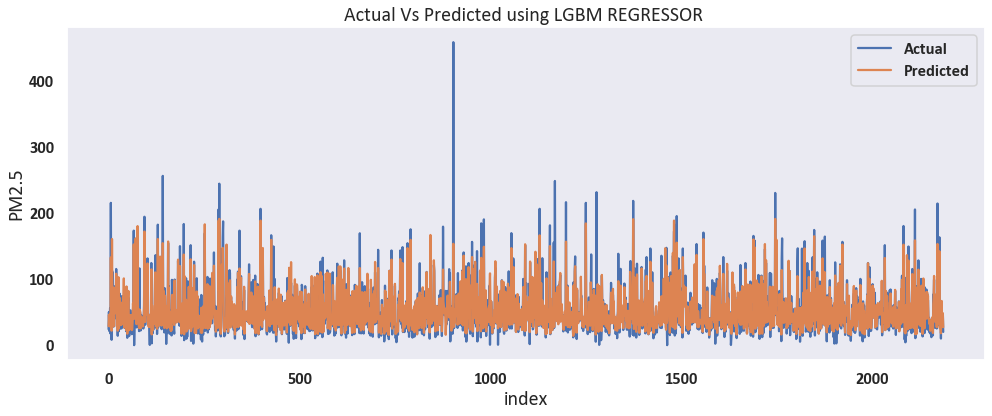

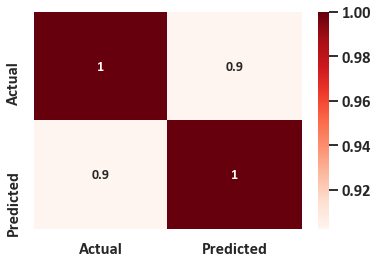

In [112]:
clf = LGBMRegressor(n_estimators=50, learning_rate=0.05, colsample_bytree=0.4, reg_alpha=2, reg_lambda=1, max_depth=-1, random_state=42)

clf.fit(important_train_features, y_train_mf) 
joblib.dump(clf, 'selected_features_lgbmregressor_mf_model.pkl')
y_pred_mf = clf.predict(important_test_features)

df_ = pd.DataFrame({'Actual': y_test_mf.flatten(), 'Predicted': y_pred_mf.flatten()})
print(df_)


get_model_metrics(y_test_mf,y_pred_mf)
visualise_prediction_vs_actual(df_, 'LGBM REGRESSOR ')

actual_predicted_correlations =df_.corr()
correlations = df_['Actual'].corr(df_['Predicted'])
all_features_corr_plot = sns.heatmap(actual_predicted_correlations, annot=True, cmap=plt.cm.Reds)
plt.show()

In [113]:
##source : https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd

## GRID SEARCH & CV

#### best 
{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'sqrt',
 'n_estimators': 100}

# Evaluating  models with multivariate dataset on held out dataset 

In [114]:
data_test[data_test.isna().any(axis=1)]

,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,...,landform_90m,landform_270m,population,dist_major_road,created_at_hour,created_at_day,created_at_dayofweek,created_at_month,created_at_week,created_at_year
773,2019-12-11 14:00:00+03:00,USEmbassy,11.409091,12.588409,0.000000,0.000000,0.724167,NaN,0.299255,32.592686,...,21,14,6834,130,14,11,2,12,50,2019
817,2019-12-11 08:00:00+03:00,USEmbassy,35.920238,44.365000,0.000000,0.000000,1.000000,NaN,0.299255,32.592686,...,21,14,6834,130,8,11,2,12,50,2019
1284,2021-01-29 16:00:00+03:00,Nakawa,27.604545,34.014091,26.737045,34.265682,NaN,23.008333,0.331740,32.609510,...,31,-11,4780,500,16,29,4,1,4,2021
1343,2019-12-11 05:00:00+03:00,USEmbassy,24.893182,29.477955,0.000000,0.000000,0.993333,NaN,0.299255,32.592686,...,21,14,6834,130,5,11,2,12,50,2019
1634,2019-12-10 23:00:00+03:00,USEmbassy,60.339091,71.590227,0.000000,0.000000,0.982500,NaN,0.299255,32.592686,...,21,14,6834,130,23,10,1,12,50,2019


In [115]:
data_test.fillna(data_test.mean(), inplace=True)

In [116]:
data_test

,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,...,landform_90m,landform_270m,population,dist_major_road,created_at_hour,created_at_day,created_at_dayofweek,created_at_month,created_at_week,created_at_year
0,2020-03-20 12:00:00+03:00,USEmbassy,9.903636,10.259545,8.852727,10.097727,0.748000,26.491667,0.299255,32.592686,...,21,14,6834,130,12,20,4,3,12,2020
1,2019-10-12 06:00:00+03:00,USEmbassy,38.428333,45.940714,40.087143,48.159762,0.995000,18.225000,0.299255,32.592686,...,21,14,6834,130,6,12,5,10,41,2019
2,2019-12-13 17:00:00+03:00,USEmbassy,13.278000,14.967333,0.000000,0.000000,0.687500,24.891667,0.299255,32.592686,...,21,14,6834,130,17,13,4,12,50,2019
3,2019-11-13 09:00:00+03:00,USEmbassy,36.304000,40.366750,89.182500,93.572500,0.868417,22.616667,0.299255,32.592686,...,21,14,6834,130,9,13,2,11,46,2019
4,2019-08-07 19:00:00+03:00,USEmbassy,56.686410,67.412308,55.048974,66.089487,0.782083,23.350000,0.299255,32.592686,...,21,14,6834,130,19,7,2,8,32,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2728,2020-01-19 00:00:00+03:00,USEmbassy,75.804091,79.502045,72.147273,80.552273,0.730833,22.300000,0.299255,32.592686,...,21,14,6834,130,0,19,6,1,3,2020
2729,2020-10-25 11:00:00+03:00,Nakawa,20.805238,22.663810,22.465238,24.824048,0.640500,26.825000,0.331740,32.609510,...,31,-11,4780,500,11,25,6,10,43,2020
2730,2021-01-13 06:00:00+03:00,Makerere,76.253333,82.311667,72.468333,81.742500,0.987333,19.291667,0.333501,32.568561,...,21,28,8518,475,6,13,2,1,2,2021
2731,2019-08-13 13:00:00+03:00,USEmbassy,37.669767,44.455581,37.168837,43.949767,0.660667,25.550000,0.299255,32.592686,...,21,14,6834,130,13,13,1,8,33,2019


In [117]:
#data_test_final = data_test.dropna()
#data_test_final = data_test
data_test[data_test.isna().any(axis=1)]
data_test.fillna(data_test.mean(), inplace=True)
data_test_mf_ = data_test[numerical_fields] #use this for other models

#data_test_mf_ = data_test[fields_to_use]
#data_test_mf_ = pd.get_dummies(data_test_mf_, columns=['created_at_hour','created_at_day', 'created_at_dayofweek', 'created_at_month', 'created_at_week','created_at_year'], prefix = ['created_at_hour','created_at_day', 'created_at_dayofweek', 'created_at_month', 'created_at_week','created_at_year'])


scaler = MinMaxScaler()
test_scaler = MinMaxScaler()

print(data_test_mf_.shape)
X_data_test = data_test_mf_.values
important_eval_test_features = X_data_test[:, important_indices]
print(X_data_test.shape)
print(important_eval_test_features.shape)
y_data_test = df_test_solution['ref_pm2_5'].values
print(y_data_test.shape)

(2733, 14)
(2733, 14)
(2733, 14)
(2733,)


In [118]:
X_data_test

array([[   9.90363636,   10.25954545,    8.85272727, ...,   14.        ,
        6834.        ,  130.        ],
       [  38.42833333,   45.94071429,   40.08714286, ...,   14.        ,
        6834.        ,  130.        ],
       [  13.278     ,   14.96733333,    0.        , ...,   14.        ,
        6834.        ,  130.        ],
       ...,
       [  76.25333333,   82.31166667,   72.46833333, ...,   28.        ,
        8518.        ,  475.        ],
       [  37.66976744,   44.4555814 ,   37.16883721, ...,   14.        ,
        6834.        ,  130.        ],
       [  52.72466667,   65.39866667,   50.352     , ...,   28.        ,
        8518.        ,  475.        ]])

2733
[30.  44.  27.  ... 54.  42.  39.4]
      Actual  Predicted
0       30.0  23.981678
1       44.0  52.668705
2       27.0  32.854588
3       48.0  53.586666
4       57.0  81.000381
...      ...        ...
2728    75.0  98.174873
2729    24.2  37.968845
2730    54.0  66.456211
2731    42.0  62.895206
2732    39.4  51.036060

[2733 rows x 2 columns]
Mean Absolute Error:  15.687575748190966
Root Mean Squared Error:  21.53120658616845
Mean Squared Error:  463.59285705626365
Correlation:  0.9091239629412706
R-Squared Value:  0.8265


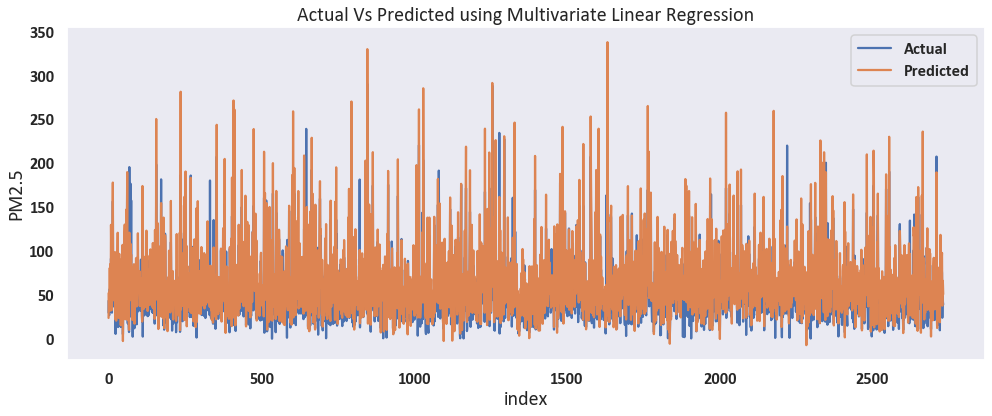

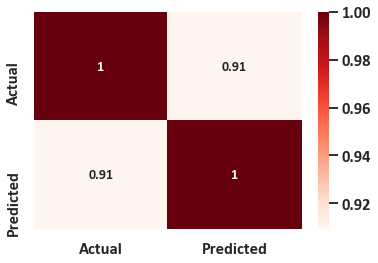

In [123]:
scaled_evaluation_features_original = test_scaler.fit_transform(X_data_test)
                     
regressor_loaded = joblib.load('mlr_regressor_model_scaled.pkl')
y_pred_eval = regressor_loaded.predict(scaled_evaluation_features_original)
print(len(y_pred_eval))
print(y_data_test)
df_ = pd.DataFrame({'Actual': y_data_test.flatten(), 'Predicted': y_pred_eval.flatten()})
print(df_)

get_model_metrics(y_data_test, y_pred_eval)
visualise_prediction_vs_actual(df_, 'Multivariate Linear Regression')

actual_predicted_correlations =df_.corr()
correlations = df_['Actual'].corr(df_['Predicted'])
all_features_corr_plot = sns.heatmap(actual_predicted_correlations, annot=True, cmap=plt.cm.Reds)
plt.show()


In [120]:
### evaluating svr with multiple features on held out test data

      Actual  Predicted
0       30.0  26.836441
1       44.0  46.381982
2       27.0  28.497987
3       48.0  47.606167
4       57.0  76.394163
...      ...        ...
2728    75.0  97.119273
2729    24.2  34.825784
2730    54.0  55.060048
2731    42.0  53.981348
2732    39.4  42.983066

[2733 rows x 2 columns]
Mean Absolute Error:  10.311183884866656
Root Mean Squared Error:  16.57980292040045
Mean Squared Error:  274.8898648793193
Correlation:  0.9149951688435553
R-Squared Value:  0.8372


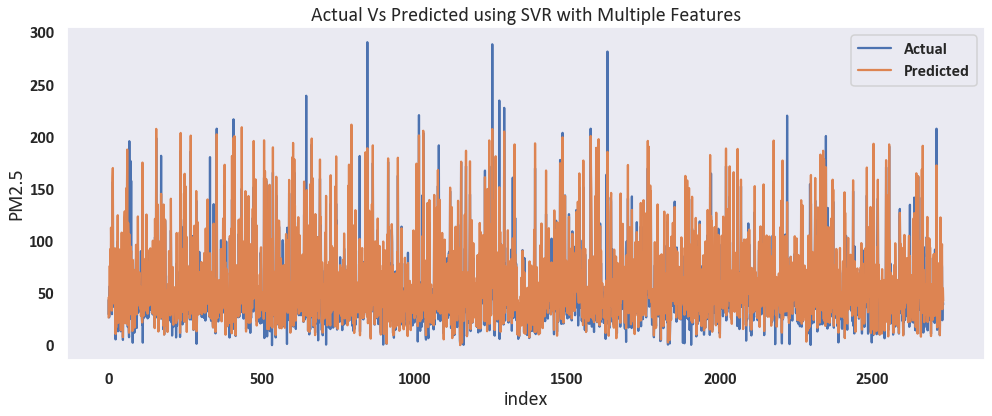

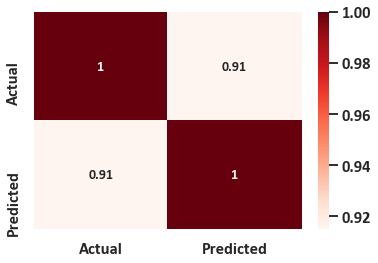

In [121]:
scaled_evaluation_features_original = test_scaler.fit_transform(X_data_test)
                     
mf_svr_loaded = joblib.load('mlr_svr_model.pkl')
y_pred_eval = mf_svr_loaded.predict(scaled_evaluation_features_original)
#print(len(y_pred_eval))
#print(y_data_test)
df_ = pd.DataFrame({'Actual': y_data_test.flatten(), 'Predicted': y_pred_eval.flatten()})
print(df_)

get_model_metrics(y_data_test, y_pred_eval)
visualise_prediction_vs_actual(df_, 'SVR with Multiple Features')

actual_predicted_correlations =df_.corr()
correlations = df_['Actual'].corr(df_['Predicted'])
all_features_corr_plot = sns.heatmap(actual_predicted_correlations, annot=True, cmap=plt.cm.Reds)
plt.show()


      Actual  Predicted
0       30.0     26.030
1       44.0     40.530
2       27.0     28.560
3       48.0     65.538
4       57.0     63.980
...      ...        ...
2728    75.0     82.330
2729    24.2     32.351
2730    54.0     52.217
2731    42.0     45.550
2732    39.4     38.677

[2733 rows x 2 columns]
Mean Absolute Error:  7.348732162458836
Root Mean Squared Error:  13.454132692558241
Mean Squared Error:  181.0136865089645
Correlation:  0.9257960454291473
R-Squared Value:  0.8571


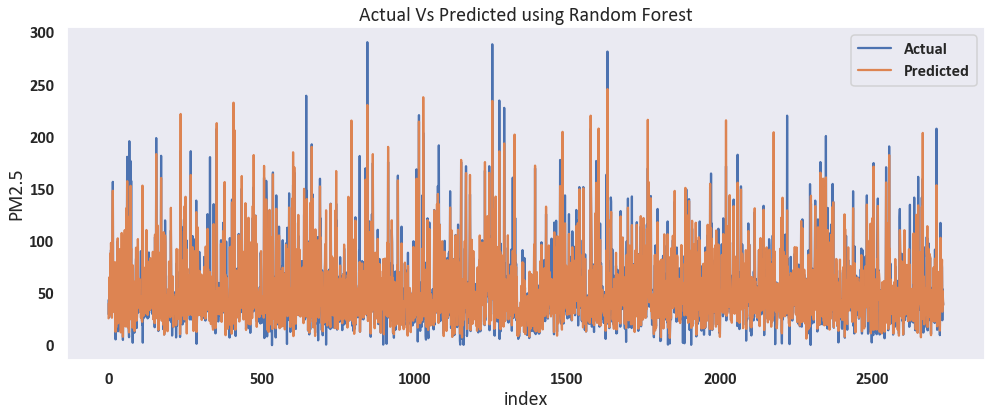

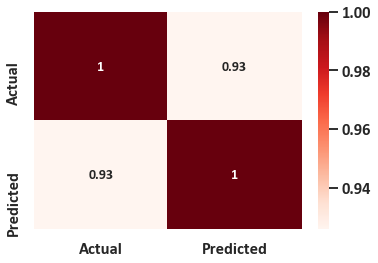

In [122]:
                    
mf_rf_loaded = joblib.load('selected_features_randomforest_mf_model.pkl')
#y_pred_eval = mf_rf_loaded.predict(X_data_test)
y_pred_eval = mf_rf_loaded.predict(important_eval_test_features)

#print(len(y_pred_eval))
#print(y_data_test)
df_ = pd.DataFrame({'Actual': y_data_test.flatten(), 'Predicted': y_pred_eval.flatten()})
print(df_)

get_model_metrics(y_data_test, y_pred_eval)
visualise_prediction_vs_actual(df_, 'Random Forest')

actual_predicted_correlations =df_.corr()
correlations = df_['Actual'].corr(df_['Predicted'])
all_features_corr_plot = sns.heatmap(actual_predicted_correlations, annot=True, cmap=plt.cm.Reds)
plt.show()
